- era の 4 のあまり毎に学習

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

import os
import sys
import json
import gc
import pickle 


from numerapi import NumerAPI
from numerai_tools.scoring import numerai_corr, correlation_contribution

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import lightgbm as lgb

sys.path.append("../")
from src.model import MLModel, LightGBMModel
from src.validation import caluculate_metrics

# Config

In [3]:
class cfg:
    exp = "exp009"
    dataset_path = "../dataset/v5.0"
    feature_set = "medium"
    
    model_params = {
        "objective": "regression",
        "metric": "l2",
        "n_estimators": 2000,
        "max_depth": 5,
        "learning_rate": 0.01,
        "feature_fraction": 0.1,
        "seed": 42,
    }


In [4]:
# 実験用フォルダ作成    
os.makedirs(cfg.exp, exist_ok=True)

# 辞書形式に変換して保存 (推論時に使用する)
cfg_dict = {attr: getattr(cfg, attr) for attr in dir(cfg) if not attr.startswith("__") and not callable(getattr(cfg, attr))}
config_file = os.path.join(cfg.exp, "training_config.json")
with open(config_file, "w") as f:
    json.dump(cfg_dict, f, indent=4)

with open(f"{cfg.dataset_path}/features.json", "r") as f:
    feature_metadata = json.load(f)

# print(feature_metadata.keys())
feature_sets = feature_metadata["feature_sets"]
# print(feature_sets.keys())
feature_set = feature_sets[cfg.feature_set][:80]
print(f"feature col length: {len(feature_set)}")

feature col length: 80


# Load Data

In [5]:
train = pd.read_parquet(
    f"{cfg.dataset_path}/train.parquet",
    columns=["era", "target"] + feature_set
)

valid = pd.read_parquet(
    f"{cfg.dataset_path}/validation.parquet",
    columns=["era", "target"] + feature_set
)

print(train.shape)
display(train.head(2))

print(valid.shape)
display(valid.head(2))

(2746270, 82)


,era,target,feature_able_deprived_nona,feature_ablest_inflexional_egeria,feature_absorbable_hyperalgesic_mode,feature_accoutered_revolute_vexillology,feature_acetose_crackerjack_needlecraft,feature_acheulian_conserving_output,feature_acronychal_bilobate_stevenage,feature_acrylic_gallic_wine,...,feature_canine_umpteenth_bidding,feature_canonistic_disallowable_counterbore,feature_catechetical_paragogical_accouterment,feature_celibate_wayworn_cosmism,feature_cephalate_unfine_molality,feature_cervical_swell_tunisia,feature_champion_arabic_teetotum,feature_chaste_disqualifying_intermodulation,feature_chattier_tight_academic,feature_cheeky_african_waikiki
id,,,,,,,,,,,,,,,,,,,,,
n0007b5abb0c3a25,0001,0.25,1,2,3,2,3,2,2,2,...,3,4,0,2,2,3,2,2,3,2
n003bba8a98662e4,0001,0.25,3,2,4,1,0,2,3,2,...,2,4,3,2,2,4,1,2,3,2


(3565569, 82)


,era,target,feature_able_deprived_nona,feature_ablest_inflexional_egeria,feature_absorbable_hyperalgesic_mode,feature_accoutered_revolute_vexillology,feature_acetose_crackerjack_needlecraft,feature_acheulian_conserving_output,feature_acronychal_bilobate_stevenage,feature_acrylic_gallic_wine,...,feature_canine_umpteenth_bidding,feature_canonistic_disallowable_counterbore,feature_catechetical_paragogical_accouterment,feature_celibate_wayworn_cosmism,feature_cephalate_unfine_molality,feature_cervical_swell_tunisia,feature_champion_arabic_teetotum,feature_chaste_disqualifying_intermodulation,feature_chattier_tight_academic,feature_cheeky_african_waikiki
id,,,,,,,,,,,,,,,,,,,,,
n000101811a8a843,0575,0.75,2,1,2,4,0,4,0,0,...,0,2,0,0,0,0,4,0,2,3
n001e1318d5072ac,0575,0.00,0,2,2,3,2,3,0,0,...,2,4,4,3,3,4,3,3,4,1


# Preprocess

In [7]:
# target が 20 日、 era が週次なので重複してる。ので era を間引く
train["era_int"] = train["era"].astype(int)

# Training

In [8]:
features = feature_set

In [9]:
models = []

for i in range(4):
    cond_train = train["era_int"] % 4 == i
    tmp_train = train.loc[cond_train]

    model = LightGBMModel(
        model_params=cfg.model_params,
    )
    model.train(
        tmp_train[features],
        tmp_train["target"],
        eval_set=(valid[features], valid["target"]),
        early_stopping_rounds=10
    )

    model.save_model(os.path.join(cfg.exp, f"model_{i}.pkl"))
    models.append(model)

with open(os.path.join(cfg.exp, "feature.pkl"), "wb") as f:
     pickle.dump(features, f)

        
# del train; gc.collect()

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400
[LightGBM] [Info] Number of data points in the train set: 684735, number of used features: 80
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003816 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400
[LightGBM] [Info] Number of data points in the train set: 688184, number of used features: 80
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001802 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400
[LightGBM] [Info] Number of data points in the train set: 689317, number of used features: 80
[LightGBM] [Warning] Provided parameters cons

/home/kouya-takahashi/.local/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Warning] Provided parameters constrain tree depth (max_depth=5) without explicitly setting 'num_leaves'. This can lead to underfitting. To resolve this warning, pass 'num_leaves' (<=32) in params. Alternatively, pass (max_depth=-1) and just use 'num_leaves' to constrain model complexity.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400
[LightGBM] [Info] Number of data points in the train set: 684034, number of used features: 80
[LightGBM] [Warning] Provided parameters cons

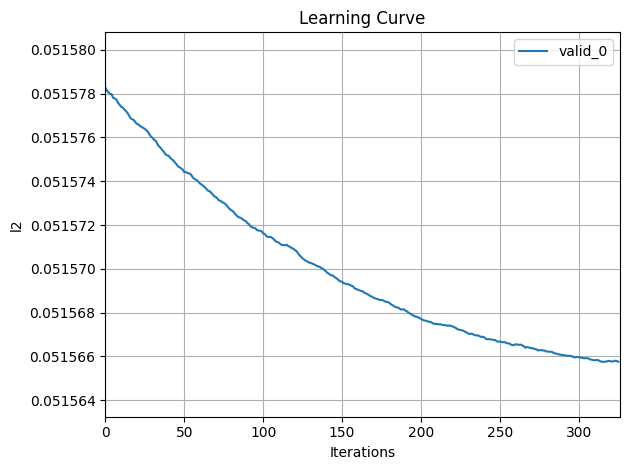

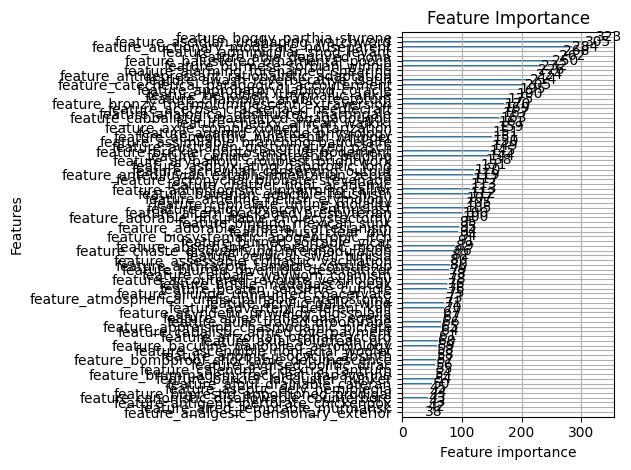

In [10]:
model.visualize_learning_curve()
model.visualize_feature_importance()

# Validation

In [11]:
preds = np.zeros(len(valid))

for model in models:
    preds += model.predict(valid[features]) / len(models)

valid["pred"] = preds

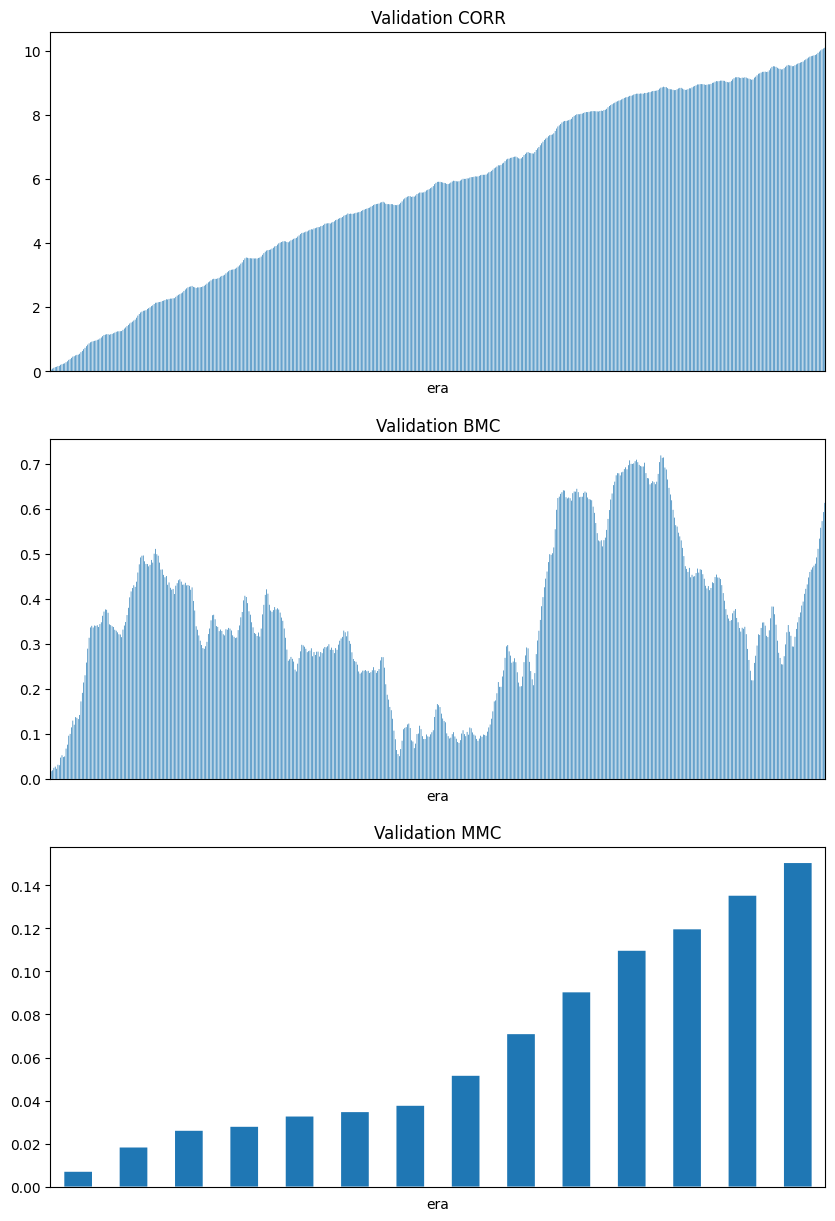

,corr_mean,corr_std,corr_shape,corr_max_drawdown,mmc_mean,mmc_std,mmc_shape,mmc_max_drawdown,bmc_mean,bmc_std,bmc_shape,bmc_max_drawdown
0,0.017659,0.01942,0.909289,0.107403,0.010742,0.006521,1.647207,0.0,0.001072,0.01349,0.079437,0.499535


In [12]:
caluculate_metrics(cfg.dataset_path, valid)